In [31]:
# Headers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage.feature import greycomatrix, greycoprops
import cv2  
from numpy.linalg import det
from skimage import util, exposure
from math import sqrt, ceil
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [32]:
# global variables
black_value = np.float64(-1408.5106382978724)
images_filename = 'tr_im.nii'
masks_filename = 'tr_mask.nii'

In [33]:
def get_vals(mask):
    vals = []
    x, y = mask.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j] not in vals:
                vals.append(mask[i][j])

    vals.remove(0)
    return vals

In [34]:
def apply_mask(img, mask, class_id):
    heigh, width = img.shape
    tmp = deepcopy(img)
    lineal_array = np.array(0)
    for x in range(heigh):
        for y in range(width):
            # Set pixel as black color if is not inside this mask
            if mask[x,y] != np.float64(class_id):
                tmp[x,y] = black_value
            # Count pixels inside this mask
            else:
                lineal_array = np.append(lineal_array, tmp[x,y])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    lineal_array = np.delete(lineal_array, 0)
    return tmp, lineal_to_matrix(lineal_array)

In [35]:
def calculate_media_lineal_arr(array):
    length = array.shape[0]
    media = np.float64(0)
    for x in range(length):
        media += array[x]
    media = media/length
    return media

In [36]:
def lineal_to_matrix(lineal_array):
    sqrt_ = ceil(sqrt(lineal_array.shape[0]))
    media = calculate_media_lineal_arr(lineal_array)
    missing_values = sqrt_**2 - lineal_array.shape[0]
    # Complete square matrix
    for x in range(missing_values):
        lineal_array = np.append(lineal_array, media)
    
    return lineal_array.reshape([sqrt_, sqrt_])

In [37]:
def show_slice_mask(slicei, mask):
    """ Function to display images and mask """
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slicei.T,  cmap="gray", origin="lower")
    ax[0].set_title('Image')
    ax[1].imshow(mask.T, cmap="gray", origin="lower")
    ax[1].set_title('Mask')
    plt.show()

In [78]:
def glcm_properties(image):
    distancias = [1,2,3]
    #0 -> Oeste a este, np.pi/4 -> diagonal hacia abajo, np.pi/2 -> Norte a sur
    angulos = [0, np.pi/4, np.pi/2]

    # Calculate properties for just one superpixel using the
    # respective mask  
    glcm = greycomatrix(image, 
                        distances = distancias, 
                        angles = angulos,
                        symmetric=True, 
                        normed=True)
    energyResults = greycoprops(glcm, 'energy')
    homogeneityResults = greycoprops(glcm, 'homogeneity')
    contrastResults = greycoprops(glcm, 'contrast')
    #correlationResults = greycoprops(glcm, 'correlation')
    #dissimilarityResults = greycoprops(glcm, 'dissimilarity')
    
    return [energyResults, homogeneityResults, contrastResults] #, correlationResults, dissimilarityResults]

In [103]:
def training(imgs, masks):
    height, width, num_images = imgs.shape
    classes_dict = {}
    for x in range(3):
        added = [0 , 0, 0]
        classes = get_vals(masks[:,:,x])
        for j in classes:
            if not int(j) in classes_dict:
                classes_dict[int(j)] = [[0, 0], [0, 0], [0, 0]]
            
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            props = glcm_properties(matrix_mask.astype(np.uint8))
            for z in range(len(props)):
                if int(j) == 2:
                    print(int(j), z)
                if isinstance(classes_dict[int(j)][z], np.ndarray):
                    classes_dict[int(j)][z][0] += props[z]
                    classes_dict[int(j)][z][1] += 1
                else:
                    added[z] += 1
                    classes_dict[int(j)][z][0] = props[z]
                    classes_dict[int(j)][z][1] += 1
        
        if x % 10 == 0:
            print("{} imagenes procesadas".format(x))
    #for id_ in classes_dict.keys():
        #classes_dict[id_]
    print("dict")
    print(classes_dict)

In [104]:
def main():
    to_show = 3
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()
    training(imgs, masks)
    for x in range(3):
        print("Image no ", x)
        classes = get_vals(masks[:,:,x])
        show_slice_mask(imgs[:,:,x], masks[:,:,x])
        """
        for j in classes:
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            print("class ", j)
            print(type(matrix_mask))
            #show_slice_mask(tmp, masks[:,:,x])
            show_slice_mask(tmp, matrix_mask)
            print(glcm_properties(matrix_mask.astype(np.uint8)))
            #create_matrix(tmp)
        #print(get_prop(imgs[:,:,x].astype(np.uint8), masks[:,:,x].astype(np.uint8)))
        #get_every_mask(imgs[:,:,x], masks[:,:,x])
        """

2 0
2 1
2 2
0 imagenes procesadas
2 0
2 1
2 2
dict
{2: [[array([[0.00647686, 0.00536434, 0.00536564],
       [0.00646457, 0.00536434, 0.00535809],
       [0.00646691, 0.00539048, 0.00537796]]), 2], [array([[0.01824752, 0.01208567, 0.01253628],
       [0.0163737 , 0.01208567, 0.01178282],
       [0.01548835, 0.01234965, 0.01237651]]), 2], [array([[10357.07131029, 10924.94225348, 11047.29814112],
       [10999.71375644, 10924.94225348, 11074.11520082],
       [10999.53478707, 10974.79663086, 11097.45857397]]), 2]], 1: [[array([[0.03708921, 0.0257956 , 0.02558199],
       [0.03710304, 0.0257956 , 0.02600163],
       [0.03709974, 0.02684552, 0.02617474]]), 3], [array([[0.05268503, 0.01399901, 0.01668898],
       [0.04409799, 0.01399901, 0.01484665],
       [0.03812452, 0.0113375 , 0.01226582]]), 3], [array([[ 8261.95935961, 13193.42346939, 13141.71921182],
       [11066.74840358, 13193.42346939, 15173.18390805],
       [12245.86074271, 14784.66803841, 14588.81564987]]), 3]], 3: [[array([[0

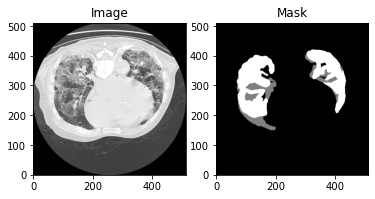

Image no  1


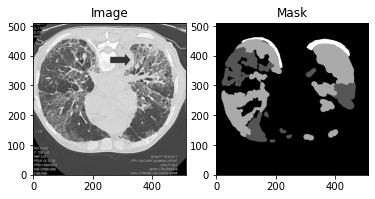

Image no  2


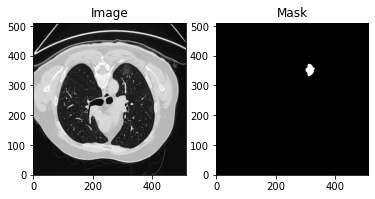

In [105]:
main()